In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras
from sklearn.preprocessing import StandardScaler, PowerTransformer, MaxAbsScaler, Normalizer, RobustScaler, minmax_scale, QuantileTransformer

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('../input/historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [3]:
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

In [4]:
trainSet.head()

,ticker,open,close,adj_close,low,high,volume
date,,,,,,,
2015-01-02,A,41.180000,40.560001,39.161114,40.369999,41.310001,1529200
2015-01-05,A,40.320000,39.799999,38.427319,39.700001,40.459999,2041800
2015-01-06,A,39.810001,39.180000,37.828701,39.020000,40.020000,2080600
2015-01-07,A,39.520000,39.700001,38.330769,39.290001,39.810001,3359700
2015-01-08,A,40.240002,40.889999,39.479725,40.180000,40.980000,2116300


In [5]:
symbols = trainSet.ticker.unique()

In [ ]:
symbols[:100]

In [6]:
timesteps = 60
def make_samples(
    data_1,
    data_2,
    s):
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        x_2 = data_2[i-timesteps:i, 0]

        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    x_2 = x_2.reshape(-1,1)                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    
                    train_set[s]['x_1'][j].append(sc.transform(x_1))
                    train_set[s]['y'][j].append(sc.transform(y))
                    sc = MinMaxScaler(feature_range=(0,1))
                    train_set[s]['x_2'][j].append(sc.fit_transform(x_2))
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True

In [7]:
# Define train_set
train_set = {}
prediction_intervals = [1,3,5,10]
for s in symbols:
    train_set.update({s:{
        'x_1':{},
        'x_2':{},
        'y':{},
    }})
    for i in prediction_intervals:
        train_set[s]['x_1'][i] = []
        train_set[s]['x_2'][i] = []
        train_set[s]['y'][i] = []
    
    data_1 = trainSet.loc[trainSet['ticker'] == s][['adj_close']].values
    data_2 = trainSet.loc[trainSet['ticker'] == s][['volume']].values
  
    make_samples(
        data_1, 
        data_2, 
        s)
    
    if s == 'AEGN':
        break

In [8]:
for s in train_set:
    for i in train_set[s]['y']:
        x_1 = train_set[s]['x_1'][i]
        x_2 = train_set[s]['x_2'][i]
        y = train_set[s]['y'][i]
        train_set[s]['x_1'][i] = np.array(x_1)
        train_set[s]['x_2'][i] = np.array(x_2)
        train_set[s]['y'][i] = np.array(y)

In [9]:
train_set['AAPL']['x_1'][1].shape

(695, 60, 1)

In [10]:
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, mode='min', restore_best_weights=True)

In [11]:
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units = 30, return_sequences = False, input_shape=(2,60), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

In [12]:
model = {}
model_history = {}
for i in prediction_intervals:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    
    n_epoch = 100
    x_train = []
    y_train = []
    
    for s in train_set:
        for j in range (0, len(train_set[s]['x_1'][i])):
            x = [
                train_set[s]['x_1'][i][j],
                train_set[s]['x_2'][i][j],
            ]
            x_train.append(x)
        for j in train_set[s]['y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0])
    
    print(X_train.shape, Y_train.shape)
    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

(59622, 2, 60) (59622,)
Fitting prediction interval 1  model
Train on 41735 samples, validate on 17887 samples
Epoch 1/100
41735/41735 [==============================] - 2s 47us/step - loss: 0.3115 - val_loss: 0.1127
Epoch 2/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.1278 - val_loss: 0.0923
Epoch 3/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.1071 - val_loss: 0.0780
Epoch 4/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0915 - val_loss: 0.0678
Epoch 5/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0805 - val_loss: 0.0604
Epoch 6/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0731 - val_loss: 0.0644
Epoch 7/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0704 - val_loss: 0.0513
Epoch 8/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0616 - val_loss: 0.0545
Epoch 9/100
41735/41735 [=======================

41735/41735 [==============================] - 0s 3us/step - loss: 0.0219 - val_loss: 0.0165
Epoch 78/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0228 - val_loss: 0.0170
(59426, 2, 60) (59426,)
Fitting prediction interval 3  model
Train on 41598 samples, validate on 17828 samples
Epoch 1/100
41598/41598 [==============================] - 1s 17us/step - loss: 0.2507 - val_loss: 0.1211
Epoch 2/100
41598/41598 [==============================] - 0s 2us/step - loss: 0.1434 - val_loss: 0.0970
Epoch 3/100
41598/41598 [==============================] - 0s 2us/step - loss: 0.1177 - val_loss: 0.0823
Epoch 4/100
41598/41598 [==============================] - 0s 2us/step - loss: 0.1012 - val_loss: 0.0745
Epoch 5/100
41598/41598 [==============================] - 0s 2us/step - loss: 0.0916 - val_loss: 0.0718
Epoch 6/100
41598/41598 [==============================] - 0s 2us/step - loss: 0.0857 - val_loss: 0.0672
Epoch 7/100
41598/41598 [==============================] - 

41461/41461 [==============================] - 0s 2us/step - loss: 0.0652 - val_loss: 0.0572
Epoch 19/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0646 - val_loss: 0.0594
Epoch 20/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0630 - val_loss: 0.0564
Epoch 21/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0625 - val_loss: 0.0585
Epoch 22/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0612 - val_loss: 0.0554
Epoch 23/100
41461/41461 [==============================] - 0s 3us/step - loss: 0.0619 - val_loss: 0.0554
Epoch 24/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0608 - val_loss: 0.0542
Epoch 25/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0591 - val_loss: 0.0575
Epoch 26/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0594 - val_loss: 0.0530
Epoch 27/100
41461/41461 [==============================] -

41118/41118 [==============================] - 0s 2us/step - loss: 0.0709 - val_loss: 0.0713
Epoch 53/100
41118/41118 [==============================] - 0s 2us/step - loss: 0.0708 - val_loss: 0.0685
Epoch 54/100
41118/41118 [==============================] - 0s 2us/step - loss: 0.0707 - val_loss: 0.0748
Epoch 55/100
41118/41118 [==============================] - 0s 2us/step - loss: 0.0705 - val_loss: 0.0685
Epoch 56/100
41118/41118 [==============================] - 0s 2us/step - loss: 0.0703 - val_loss: 0.0743
Epoch 57/100
41118/41118 [==============================] - 0s 2us/step - loss: 0.0708 - val_loss: 0.0683
Epoch 58/100
41118/41118 [==============================] - 0s 2us/step - loss: 0.0694 - val_loss: 0.0685
Epoch 59/100
41118/41118 [==============================] - 0s 2us/step - loss: 0.0715 - val_loss: 0.0711
Epoch 60/100
41118/41118 [==============================] - 0s 2us/step - loss: 0.0697 - val_loss: 0.0682
Epoch 61/100
41118/41118 [==============================] -

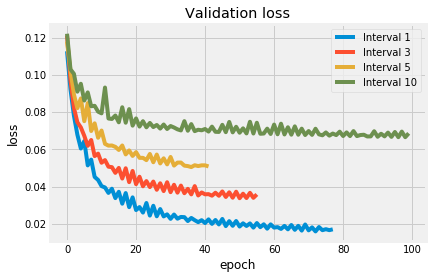

In [13]:
for i in prediction_intervals:
    plt.plot(model_history[i].history['val_loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Interval 1', 'Interval 3', 'Interval 5', 'Interval 10'], loc='upper right')
plt.show()

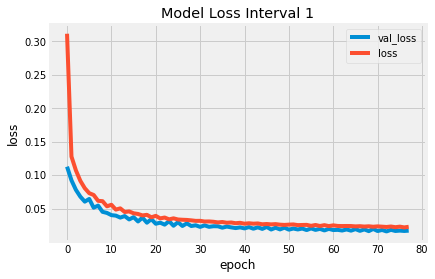

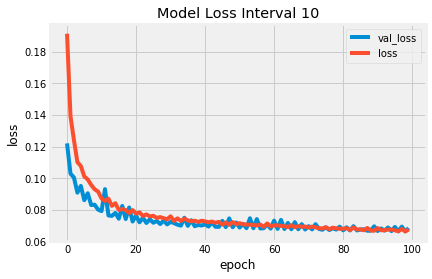

In [14]:
for i in [1,10]:
    plt.plot(model_history[i].history['val_loss'])
    plt.plot(model_history[i].history['loss'])
    plt.title('Model Loss Interval {}'.format(i))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'loss'], loc='upper right')
    plt.show()

In [15]:
# Calculate Mean squared_error #
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [16]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

In [17]:
def make_test_data(s):
    scaler = {s:{}}
    test_set = {s:{}}
    test_set.update({s:{
            'x_1':{},
            'x_2':{},
            'y':{},
        }})
    for i in prediction_intervals:
            test_set[s]['x_1'][i] = []
            test_set[s]['x_2'][i] = []
            test_set[s]['y'][i] = []
            scaler[s][i] = []

    data_1 = testSet.loc[testSet['ticker'] == s][['adj_close']].values
    data_2 = testSet.loc[testSet['ticker'] == s][['volume']].values

    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        x_2 = data_2[i-timesteps:i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    x_2 = x_2.reshape(-1,1)
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    scaler[s][j].append(sc)
                    test_set[s]['x_1'][j].append(sc.transform(x_1))
                    test_set[s]['y'][j].append(y)
                    sc = MinMaxScaler(feature_range=(0,1))
                    test_set[s]['x_2'][j].append(sc.fit_transform(x_2))
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True
                    
    return test_set, scaler

In [18]:
def make_prediction(data, s, scaler):
    mse_val = {}
    y_true_val = {}
    y_pred_val = {}
    
    for i in prediction_intervals:
        x_test = []
        for j in range (0, len(data[s]['x_1'][i])):
            x = [
                data[s]['x_1'][i][j],
                data[s]['x_2'][i][j],
            ]
            x_test.append(x)

        X_test = np.array(x_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
        
        result = model[i].predict(X_test)
        y_pred = []
        for j in range(0,len(result)):
            y = result[j]
            y = y.reshape(-1,1)
            k = scaler[s][i][j].inverse_transform(y)
            y_pred.append(k[0][0])
                    
        y_test = data[s]['y'][i]
        y_true = np.array(y_test)
        y_true = y_true.reshape(y_true.shape[0])
    
        y_true_val[i] = y_true
        y_pred_val[i] = y_pred

        mse_val[i] = return_mse(y_true, y_pred) 
    return y_true_val, y_pred_val, mse_val

In [19]:
s = 'AAPL'
data, sc = make_test_data(s)
y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)

for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of AAPL inveral 1: 8.58164841415352
Test Set -> MSE of AAPL inveral 3: 25.485500045438584
Test Set -> MSE of AAPL inveral 5: 50.37156712019173
Test Set -> MSE of AAPL inveral 10: 94.70282818379012


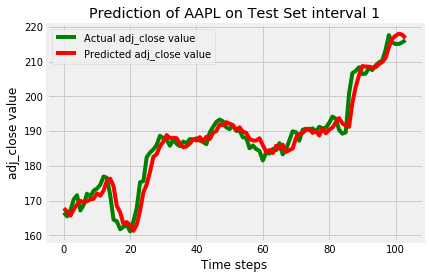

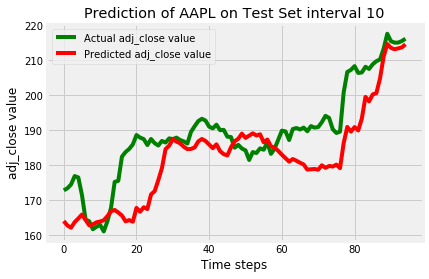

In [20]:
for i in [1,10]:
    plotting_graph(y_true_val[i], y_pred_val[i], s, 'Test Set interval {}'.format(i))

# MSE of 10 symbols

In [21]:
test_symbols = ['A','AAPL','ABAX','ACIU','ADUS']

In [22]:
all_mse = {}
for s in test_symbols:
    all_mse[s] = {}
    data, sc = make_test_data(s)
    y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)
    for i in prediction_intervals:
        all_mse[s][i] = mse_val[i]
        all_mse[s][i] = mse_val[i]

In [23]:
all_mse_1 = []
all_mse_10 = []
for s in all_mse:
    all_mse_1.append(round(all_mse[s][1], 3))
    all_mse_10.append(round(all_mse[s][10], 3))

In [24]:
all_mse_1

[1.724, 8.582, 4.373, 1.348, 2.021]

In [25]:
all_mse_10

[3.8, 94.703, 27.576, 4.986, 16.539]

In [26]:
for i in range(0, len(all_mse_1)):
    print('MSE of Interval 10 = {} Interval 1'.format(round(all_mse_10[i]/all_mse_1[i], 1)))

MSE of Interval 10 = 2.2 Interval 1
MSE of Interval 10 = 11.0 Interval 1
MSE of Interval 10 = 6.3 Interval 1
MSE of Interval 10 = 3.7 Interval 1
MSE of Interval 10 = 8.2 Interval 1
